In [1]:
# Sasha Morrison, 2.3 submission

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime as dt
from pandas_datareader import data
import gzip
import json
import io

# 1.1 Birth Rates

The data on US births, provided by the CDC is in `data/births.csv`.

Reproduce the following plot of births by gender over time given the data:

![](births_gender.png)

Note the `1e6` on the y axis for scale

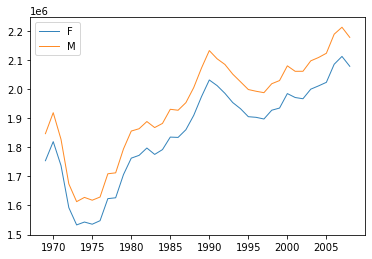

In [2]:
data_url = r'data/births.csv'
dataframe = pd.read_csv(data_url)
df = dataframe
fig, ax = plt.subplots()
fdf = df.loc[df['gender'] == 'F']
mdf = df.loc[df['gender'] == 'M']
mdf = mdf.groupby(['year']).births.sum()
fdf = fdf.groupby(['year']).births.sum()
ax.plot(fdf, linewidth=1, alpha=0.9)
ax.plot(mdf, linewidth=1, alpha=0.9)
ax.legend('FM')

# 1.2 Births anomalies

This was analyzed by beloved statistician Andrew Gelman [here](http://andrewgelman.com/2012/06/14/cool-ass-signal-processing-using-gaussian-processes/), leading to this plot:

![](births_gp100.png)

Explain all three plots in Gelman's figure. 

**1.2:** What is the periodic component? What is the residual? Use your research skills to learn then explain it (in english).  
  
    

## 1.2 Answers
Residual = The amount of deviation from the smoothed line at any given point  
Periodic = Conveys the rate and severity of cycles in the time series

# 1.3 Holiday Anomalies Plot

Reproduce *as best you can* the first of the 3 figures from Andrew Gelman's blog post (your plot may have small differences)

**1.3.1:** Reproduce the births line in a plot. Hint: Make the x axis a `pd.datetime` object

**1.3.2:** Reproduce the `smoothed` line. Hint: use a rolling window average

**1.3.3:** Reproduce the entire figure with the mean line as a horizontal. You can make the y axis total births instead of a % deviation from mean axis (they'll look the same anyway)

<ipython-input-3-b1ae153f33d3>:15: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  df.index = [ pd.datetime(2012, month, day) for (month, day) in df.index ]


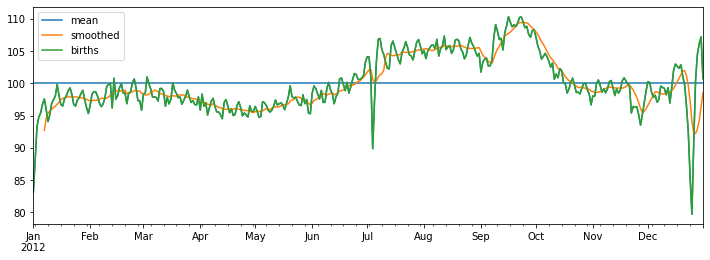

In [3]:
data_url = r'data/births.csv'
dataframe = pd.read_csv(data_url)
df = dataframe
fig, ax = plt.subplots(figsize=(12,4))

quartiles = np.percentile(df['births'], [25, 50, 75])
mu = quartiles[1]
sig = 0.74 * (quartiles[2] - quartiles[0])
df = df.query('(births > @mu - 5 * @sig) & (births < @mu + 5 * @sig)')
df = df.dropna(subset=['day'])
df = df[~(df['day']==99)]
df['day'] = df['day'].astype(int)
df.index = pd.to_datetime((10000 * df.year) + (100 * df.month) + df.day, format='%Y%m%d')
df = df.pivot_table('births', [df.index.month, df.index.day])
df.index = [ pd.datetime(2012, month, day) for (month, day) in df.index ]
df = df / df.mean() * 100
df.plot(ax=ax)
df.rolling(window=7).mean().plot(ax=ax)
df.births.plot(ax=ax)
ax.hlines(df.mean(), 0, df.index.max())
ax.legend(['mean', 'smoothed', 'births'])

# 2. Recipe Database

### 2.1 

Load the JSON recipe database we saw in lecture 4.

How many of the recipes are for breakfast food? Hint: The `description` would contain the work "breakfast"

In [5]:
with gzip.open("../Data/recipe.json.gz", 'r') as f:
    data = (line.strip().decode() for line in f)
    data_json = f"[ {','.join(data)} ]"
# needs stringIO to work,
# but didnt in lecture??
rec = pd.read_json(io.StringIO(data_json))

In [6]:
# have to use str twice cause i guess
# str.lower() returns a series that needs
# to be cast to str again?
rec.description.str.lower().str.contains('breakfast').sum()

3524

### 2.2 A simple recipe recommender

Let's build a recipe recommender: given a list of basic ingredients, find a recipe that uses all those ingredients.

Here is the list of ingredients that can be asked for:

```
['salt', 'pepper', 'oregano', 'sage', 'parsley',
 'rosemary', 'tarragon', 'thyme', 'paprika', 'cumin']
```

**Hint:** Build a new column for each of the ingredients that indicates whether that ingredient is in the recipe.

**example:**
```
recommend_ingredients(["parsley", "paprika", "tarragon"], df)

result: 
# The rows where these 3 ingredients are in the recipe
[2069, 74964, 93768, 113926, 137686, 140530, 158475, 158486, 163175, 165243]
```  
  
    
    

In [7]:
ing = ['salt', 'pepper', 'oregano', 'sage', 'parsley',
 'rosemary', 'tarragon', 'thyme', 'paprika', 'cumin']
for e in ing:
    rec[e] = rec.ingredients.str.contains(e)
df = rec[ing]

In [8]:
def recommend_ingredients(ing, df):
    st = ' & '.join(ing)
    t = df.query(st)
    return t.index

recommend_ingredients(["parsley", "paprika", "tarragon"], df)

Int64Index([2069, 74964, 93768, 113926, 137686, 140530, 158475, 158486, 163175,
            165243],
           dtype='int64')

# 3. Movies!

Recall the [Movies Dataset](https://www.kaggle.com/rounakbanik/the-movies-dataset) from lecture 4. It's made up of several tables which we've played with in lecture 4.

The tables have common columns (`id` and `movie_id`) around which you can merge and join tables.

### Find the best director

Your task is to find **The best director** in terms of average ratings of his movies. This can be from the `ratings` or `ratings_small` table, or simply the vote average in the `metadata` table. The director can be found in the `cast` table.

You will have to use all of your skills to get this done, between using groupbys and merging multiple tables together

In [9]:
def director_finder_3000(series):
    for e in eval(series):
        if e['job'] == 'Director':
            return e['name']

In [10]:
data_url = r'../Data/movie_data/credits.csv'
dataframe = pd.read_csv(data_url)
cred = dataframe
cred['director'] = cred['crew'].apply(director_finder_3000)

In [11]:
data_url = r'../Data/movie_data/movies_metadata.csv'
dataframe = pd.read_csv(data_url)
meta = dataframe

C:\Users\Sasha\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [12]:
meta['id'] = pd.to_numeric(meta['id'], errors='coerce')
meta = meta.dropna()
cred['id'] = cred['id'].astype(int)
meta['id'] = meta['id'].astype(int)

<ipython-input-12-caaa8208bc71>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta['id'] = meta['id'].astype(int)


In [13]:
df = cred.merge(meta, on='id')
df = df[['id', 'director', 'vote_average', 'vote_count']]

In [14]:
df = df.groupby('director').mean()
df.sort_values('vote_average', ascending=False).head(20)

,id,vote_average,vote_count
director,,,
Cho Jung-rae,384641.000000,8.500000,5.000000
Junichi Mori,294682.000000,8.300000,16.000000
Rocco Urbisci,13329.000000,8.100000,25.500000
Sergio Leone,429.000000,8.100000,2371.000000
Roger Allers,8587.000000,8.000000,5520.000000
Richard Marquand,1892.000000,7.900000,4763.000000
Lana Wachowski,603.000000,7.900000,9079.000000
Kenji Kamiyama,18839.000000,7.900000,31.000000
Francis Ford Coppola,240.000000,7.800000,3806.500000
